# Comparison to Other QSP Methods

In this notebook, we provide comparison of the execution time for quantum state preparation task using:

1. Our newly implemented QSP method `qsp_qubit_eff` using the multi-control Ry gate sequences via Braket

2. Qiskit's build-in `.initialize` method

3. Braket's `.unitary` method

## Result Summary

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

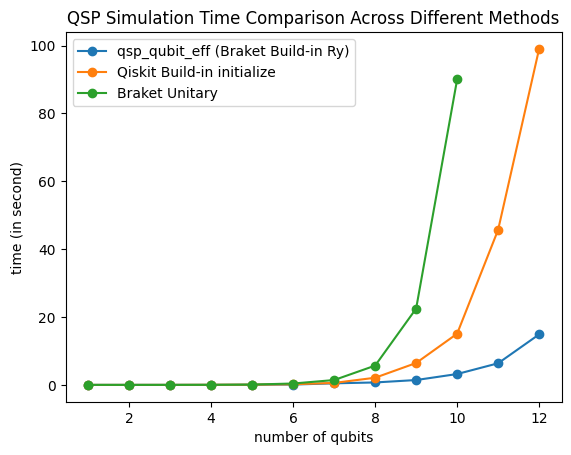

In [2]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.
n = 12
ax.plot(range(1, n + 1), [0.0124, 0.0189, 0.0203, 0.0292, 0.0635, 0.121, 0.484, 0.739, 1.45, 3.22, 6.39, 14.9], label='qsp_qubit_eff (Braket Build-in Ry)', marker='o')  # Plot some data on the axes.
ax.plot(range(1, n + 1), [0.0138, 0.0184, 0.0246, 0.0528, 0.0911, 0.204, 0.605, 2.13, 6.47, 15.1, 45.7, 99], label='Qiskit Build-in initialize', marker='o')  # Plot some data on the axes.
ax.plot(range(1, n - 2 + 1), [0.0259, 0.0183, 0.0257, 0.0429, 0.114, 0.427, 1.45, 5.70, 22.5, 90], label='Braket Unitary', marker='o')  # Plot some data on the axes.
ax.set_xlabel('number of qubits')  # Add an x-label to the axes.
ax.set_ylabel('time (in second)')  # Add a y-label to the axes.
ax.set_title("QSP Simulation Time Comparison Across Different Methods")  # Add a title to the axes.
ax.legend()  # Add a legend.

(Note that the Braket Unitary time for n = 11 and n = 12 is not report due to their longer time)

<span style="color:orange;"> Note: the actual CPU time for each data point will have slight variations. </span>

In [3]:
import numpy as np
import random
import math

from helper_functions import round_to_three_significant_digits, row_to_column_vector, generate_normalized_random_vec

In [4]:
# Import Qiskit libraries
from qiskit import QuantumCircuit
from qiskit.execute_function import execute
from qiskit import BasicAer
from qiskit import transpile
qiskit_backend = BasicAer.get_backend('statevector_simulator')

In [5]:
# Import Braket libraries
import braket
from braket.circuits import Circuit
from braket.aws import AwsDevice
from braket.devices import LocalSimulator
braket_device = LocalSimulator() # define the simulator

from qsp_circ_construction_qubit_efficient import qsp_qubit_eff

## Generate target wave function vector array

In [6]:
%%time
random.seed(10) # fix a seed for data reproduction purpose, you can change this value to play with other results
n = 3 # number of qubits. We can encode 2^n number of values with only n qubits! You can change this parameter to see what will happen for larger QSP tasks
WF_array = generate_normalized_random_vec(n)
print(row_to_column_vector(round_to_three_significant_digits(WF_array, 3))) # print out the wave function vector array for validation

[[0.349]
 [0.262]
 [0.353]
 [0.126]
 [0.497]
 [0.503]
 [0.399]
 [0.098]]
CPU times: user 350 µs, sys: 45 µs, total: 395 µs
Wall time: 404 µs


## Experiment 1: Braket QSP Timer

In [7]:
%%time
braket_qsp_circ = qsp_qubit_eff(WF_array)

CPU times: user 950 µs, sys: 17 µs, total: 967 µs
Wall time: 966 µs


In [8]:
%%time
braket_qsp_circ.state_vector() # convert the circuit to state vector
braket_result = braket_device.run(braket_qsp_circ, shots=0).result().values[0] # extract the result
print(row_to_column_vector(round_to_three_significant_digits(braket_result, 3))) # print out the resulted state vector

This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


[[0.349+0.j]
 [0.262+0.j]
 [0.353+0.j]
 [0.126+0.j]
 [0.497+0.j]
 [0.503+0.j]
 [0.399+0.j]
 [0.098+0.j]]
CPU times: user 27.3 ms, sys: 1.65 ms, total: 29 ms
Wall time: 28.4 ms


## Experiment 2: Qiskit QSP Timer

### Qiskit State Vector Simulator

In [9]:
qiskit_circ = QuantumCircuit(n)
qiskit_circ.initialize(WF_array, range(n))
# print(qiskit_circ)

In [10]:
%%time
job = execute(qiskit_circ, qiskit_backend)
qiskit_state_vector_result = job.result().get_statevector()
print(row_to_column_vector(round_to_three_significant_digits(qiskit_state_vector_result, 3))) # print out the resulted state vector

[[0.349+0.j]
 [0.262+0.j]
 [0.353+0.j]
 [0.126+0.j]
 [0.497+0.j]
 [0.503+0.j]
 [0.399+0.j]
 [0.098+0.j]]
CPU times: user 18.7 ms, sys: 4.97 ms, total: 23.7 ms
Wall time: 23.1 ms


### Qiskit QASM Simulator

We also tested the QASM simulator. The consumed time is very similar to the state vector simulation. Therefore, we only report the time result for the state vector simlulator below.

In [11]:
%%time
circ = QuantumCircuit(n)
circ.initialize(WF_array, range(n))

circ.measure_all()

# Transpile for simulator
simulator = BasicAer.get_backend('qasm_simulator')
circ = transpile(circ, simulator)

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)
# plot_histogram(counts, title='Bell-State counts')

CPU times: user 12.8 ms, sys: 588 µs, total: 13.4 ms
Wall time: 13 ms


## Experiment 3: Braket Unitary QSP Timer

In [12]:
from get_qsp_unitary import get_qsp_circ_unitary

<span style="color:orange;"> Note: the code below construct the circuit unitary to perform the QSP task. This is a brute force method, and can be further optimized. The point of this example is to show that even if we can find an efficient method to construct the unitary, the actual time to execute that unitary is way longer than the other two. </span>

In [13]:
%%time
braket_qsp_circ_unitary_matrix = get_qsp_circ_unitary(WF_array)
braket_qsp_circ_from_unitary = Circuit()
braket_qsp_circ_from_unitary.unitary(matrix=braket_qsp_circ_unitary_matrix, targets=range(n))
print(braket_qsp_circ_from_unitary)

T  : |0|
        
q0 : -U-
      | 
q1 : -U-
      | 
q2 : -U-

T  : |0|
CPU times: user 2.71 ms, sys: 1.24 ms, total: 3.96 ms
Wall time: 3.04 ms


In [14]:
%%time
braket_qsp_circ_from_unitary.state_vector() # convert the circuit to state vector
braket_result_from_unitary = braket_device.run(braket_qsp_circ_from_unitary, shots=0).result().values[0] # extract the result
print(row_to_column_vector(round_to_three_significant_digits(braket_result_from_unitary, 3))) # print out the resulted state vector

[[0.349+0.j]
 [0.262+0.j]
 [0.353+0.j]
 [0.126+0.j]
 [0.497+0.j]
 [0.503+0.j]
 [0.399+0.j]
 [0.098+0.j]]
CPU times: user 18.1 ms, sys: 383 µs, total: 18.5 ms
Wall time: 18.4 ms


## (Experiment 3.5: Braket Unitary QSP Timer, Construct Unitary from circuit)

##### <span style="color:red;"> For some reason if you simply apply the default `to_unitary` method to the circuit constructed by the build-in multi-control Ry gates, the generated unitary is incorrect. Maybe this could be something to debug on. See the results below: </span>

In [15]:
braket_qsp_circ_unitary_matrix_alt = braket_qsp_circ.to_unitary()
braket_qsp_circ_from_unitary_alt = Circuit()
braket_qsp_circ_from_unitary_alt.unitary(matrix=braket_qsp_circ_unitary_matrix_alt, targets=range(n))
print(braket_qsp_circ_from_unitary_alt)

T  : |0|
        
q0 : -U-
      | 
q1 : -U-
      | 
q2 : -U-

T  : |0|


In [16]:
%%time
braket_qsp_circ_from_unitary_alt.state_vector() # convert the circuit to state vector
braket_result_from_unitary_alt = braket_device.run(braket_qsp_circ_from_unitary_alt, shots=0).result().values[0] # extract the result
print(row_to_column_vector(round_to_three_significant_digits(braket_result_from_unitary_alt, 3))) # print out the resulted state vector

[[-0.082+0.j]
 [ 0.17 +0.j]
 [-0.235+0.j]
 [ 0.49 +0.j]
 [-0.116+0.j]
 [ 0.242+0.j]
 [-0.334+0.j]
 [ 0.696+0.j]]
CPU times: user 9.48 ms, sys: 185 µs, total: 9.67 ms
Wall time: 9.58 ms


## Experiment 4: Braket vs Qiskit: GHZ State (high Qubit Count) Construction

In [17]:
n = 24
qiskit_ghz_circ = QuantumCircuit(n)
qiskit_ghz_circ.h(0)
for i in range(n - 1):
    qiskit_ghz_circ.cx(i, i + 1)
# print(qiskit_ghz_circ)

In [18]:
%%time
job = execute(qiskit_ghz_circ, qiskit_backend)
qiskit_state_vector_result = job.result().get_statevector()
print(row_to_column_vector(round_to_three_significant_digits(qiskit_state_vector_result, 3))) # print out the resulted state vector

[[0.707+0.j]
 [0.   +0.j]
 [0.   +0.j]
 ...
 [0.   +0.j]
 [0.   +0.j]
 [0.707+0.j]]
CPU times: user 7.02 s, sys: 715 ms, total: 7.73 s
Wall time: 7.75 s


In [19]:
braket_ghz_circ = Circuit()
braket_ghz_circ.h(0)
for i in range(n - 1):
    braket_ghz_circ.cnot(i, i + 1)
# print(braket_ghz_circ)

In [20]:
%%time
braket_ghz_circ.state_vector() # convert the circuit to state vector
braket_result = braket_device.run(braket_ghz_circ, shots=0).result().values[0] # extract the result
print(row_to_column_vector(round_to_three_significant_digits(braket_result, 3))) # print out the resulted state vector

[[0.707+0.j]
 [0.   +0.j]
 [0.   +0.j]
 ...
 [0.   +0.j]
 [0.   +0.j]
 [0.707+0.j]]
CPU times: user 21.1 s, sys: 3.22 s, total: 24.4 s
Wall time: 4.57 s


## Experiment 5: Braket vs Qiskit: High Depth Circuit Construction

We repeat the following circuit for many layers, each layers with randomized Rx and Rz angles:

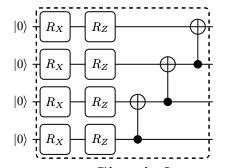

In [21]:
def generate_random_2d_array(x, y):
    # Create a list comprehension to generate rows, where each row contains 'y' random numbers between -π and π
    return [[random.uniform(-math.pi, math.pi) for _ in range(y)] for _ in range(x)]

In [22]:
layer = 3000
n = 4
rx_angles_2d_array = generate_random_2d_array(layer, n)
rz_angles_2d_array = generate_random_2d_array(layer, n)
# print(rx_angles_2d_array)

In [23]:
qiskit_high_depth_circ = QuantumCircuit(n)
for i in range(layer):
    for j in range(n):
        qiskit_high_depth_circ.rx(rx_angles_2d_array[i][j], j)
    for j in range(n):
        qiskit_high_depth_circ.rz(rz_angles_2d_array[i][j], j)
    for k in range(n - 1):
        qiskit_high_depth_circ.cx(k, k + 1)

# print(qiskit_high_depth_circ)

In [24]:
%%time
job = execute(qiskit_high_depth_circ, qiskit_backend)
qiskit_state_vector_result = job.result().get_statevector()
print(row_to_column_vector(round_to_three_significant_digits(qiskit_state_vector_result, 3))) # print out the resulted state vector

[[ 0.094+0.021j]
 [ 0.075+0.008j]
 [-0.033-0.095j]
 [ 0.005-0.04j ]
 [ 0.187-0.053j]
 [-0.172-0.033j]
 [ 0.073+0.469j]
 [ 0.111+0.199j]
 [ 0.231-0.038j]
 [-0.415-0.084j]
 [-0.033+0.038j]
 [-0.073-0.492j]
 [-0.196+0.039j]
 [ 0.202+0.123j]
 [-0.048-0.152j]
 [ 0.032-0.145j]]
CPU times: user 1.88 s, sys: 16.6 ms, total: 1.9 s
Wall time: 1.9 s


In [25]:
braket_high_depth_circ = Circuit()
for i in range(layer):
    for j in range(n):
        braket_high_depth_circ.rx(j, rx_angles_2d_array[i][j])
    for j in range(n):
        braket_high_depth_circ.rz(j, rz_angles_2d_array[i][j])
    for k in range(n - 1):
        braket_high_depth_circ.cnot(k, k + 1)

# print(braket_high_depth_circ)

In [26]:
%%time
braket_high_depth_circ.state_vector() # convert the circuit to state vector
braket_result = braket_device.run(braket_high_depth_circ, shots=0).result().values[0] # extract the result
print(row_to_column_vector(round_to_three_significant_digits(braket_result, 3))) # print out the resulted state vector

[[ 0.094+0.021j]
 [ 0.231-0.038j]
 [ 0.187-0.053j]
 [-0.196+0.039j]
 [-0.033-0.095j]
 [-0.033+0.038j]
 [ 0.073+0.469j]
 [-0.048-0.152j]
 [ 0.075+0.008j]
 [-0.415-0.084j]
 [-0.172-0.033j]
 [ 0.202+0.123j]
 [ 0.005-0.04j ]
 [-0.073-0.492j]
 [ 0.111+0.199j]
 [ 0.032-0.145j]]
CPU times: user 9.36 s, sys: 73.6 ms, total: 9.44 s
Wall time: 9.46 s
